In [ ]:
import os
os.chdir('/root/projects/train')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# What is about  ?

Notebook for CayleyPy project - ML-methods for group theory and Cayley graphs pathfiding.

See papers: https://arxiv.org/abs/2502.18663 , https://arxiv.org/abs/2502.13266 




# Main Params

In [2]:
CFG = {}

###########################################################################
# What permutation group:
###########################################################################
CFG['n_cube_size']  = 3 #  n_permutations_length
n_cube_size = CFG['n_cube_size']

# 3086 lr1e-5 e16000rw1k nbt8 bsnbt32 n16b1 rwlenDiam

###########################################################################
# Random walks paramsWhat is about ?
###########################################################################
CFG['random_walks_type'] =  'non-backtracking-beam' # 'simple' #    'simple' #
CFG['n_random_walk_length']  = 30

CFG['n_random_walks_to_generate']  =  1000 # Affects training time - linearly
CFG['n_random_walks_steps_back_to_ban']  =  8 #   used only for non-backtracking random walks

###########################################################################
# Neural Net params
###########################################################################
CFG['model_type'] = 'MLP'
CFG['list_layers_sizes'] = [4096]  # [1024, 1024, 1024] #  [128, 128, 128]
CFG['n_epochs'] = 10
CFG['batch_size'] =  1024#  8192# 64#
CFG['lr'] = 1e-3

CFG['optimizer_type'] = 'AdamW'
CFG['weight_decay'] = 1e-5 # used for AdamW
CFG['scheduler'] = False #  True

###########################################################################
# DQN training
###########################################################################
CFG['n_epochs_dqn'] = 16000
CFG['flag_dqn_round'] = False
CFG['n_random_walks_to_generate_dqn'] = 1_000 # CFG['n_random_walks_to_generate']

###########################################################################
# Beam search
###########################################################################
CFG['beam_search_torch'] = True # Launch or not fast version of beam search (currently not returns paths - just lenght)
CFG['beam_search_Fironov'] = False # Launch or not Fironov's version of beam search (better for tests)

# beam_width - key param of beam search:
CFG['beam_width']  =  1# 2**16 # 8192#  1024 # 100#  2**17
# Steps limit in beam search:
CFG['n_steps_limit']  =  30
# Coefficient to combine previous cost and new value typically 0...1 (attenuation of history)
CFG['alpha_previous_cost_accumulation']  =  0
# What heuristics to use:
CFG['beam_search_models_or_heuristics'] =  'model_torch'; # 'Hamming' , 'model_with_predict': # Catboost or Sklearn
# Specific to LRX param: to apply X or not depending on v0 and v1
# Condition proposed by S.Fironov - it is rather natural, but seems not always optimal
CFG['ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted'] = False # False # True
CFG['n_beam_search_steps_back_to_ban'] = 32 # True

###########################################################################
# What to solve:
###########################################################################
CFG['solve_random_or_longest_state'] = 'solve_random_state' # 'solve_LRX_longest' #

###########################################################################
###########################################################################
# Print/Save CFG
###########################################################################
print(CFG)
print()
for k in CFG:
    print(k,':',CFG[k])

# Save CFG-dictionary to a JSON file
import json
with open('CFG.json', 'w') as json_file:
    json.dump(CFG, json_file)


{'n_cube_size': 3, 'random_walks_type': 'non-backtracking-beam', 'n_random_walk_length': 30, 'n_random_walks_to_generate': 1000, 'n_random_walks_steps_back_to_ban': 8, 'model_type': 'MLP', 'list_layers_sizes': [4096], 'n_epochs': 10, 'batch_size': 1024, 'lr': 0.001, 'optimizer_type': 'AdamW', 'weight_decay': 1e-05, 'scheduler': False, 'n_epochs_dqn': 16000, 'flag_dqn_round': False, 'n_random_walks_to_generate_dqn': 1000, 'beam_search_torch': True, 'beam_search_Fironov': False, 'beam_width': 1, 'n_steps_limit': 30, 'alpha_previous_cost_accumulation': 0, 'beam_search_models_or_heuristics': 'model_torch', 'ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted': False, 'n_beam_search_steps_back_to_ban': 32, 'solve_random_or_longest_state': 'solve_random_state'}

n_cube_size : 3
random_walks_type : non-backtracking-beam
n_random_walk_length : 30
n_random_walks_to_generate : 1000
n_random_walks_steps_back_to_ban : 8
model_type : MLP
list_layers_sizes : [4096]
n_epochs : 10
batch_size : 1024


# Preliminaries

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import time
t0start = time.time()

import matplotlib.pyplot as plt
import seaborn as sns

import torch.optim as optim

from torch.distributions import Categorical
from tqdm.auto import tqdm

import torch

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Generators

In [4]:
n = CFG['n_cube_size']**2*6
print('n=', n)

dict_generators = {
    'U': [6, 3, 0, 7, 4, 1, 8, 5, 2, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 47, 21, 22, 50, 24, 25, 53, 27, 28, 38, 30, 31, 41, 33, 34, 44, 36, 37, 20, 39, 40, 23, 42, 43, 26, 45, 46, 29, 48, 49, 32, 51, 52, 35],
    'D': [0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 12, 9, 16, 13, 10, 17, 14, 11, 36, 19, 20, 39, 22, 23, 42, 25, 26, 45, 28, 29, 48, 31, 32, 51, 34, 35, 27, 37, 38, 30, 40, 41, 33, 43, 44, 18, 46, 47, 21, 49, 50, 24, 52, 53],
    'L': [44, 43, 42, 3, 4, 5, 6, 7, 8, 45, 46, 47, 12, 13, 14, 15, 16, 17, 24, 21, 18, 25, 22, 19, 26, 23, 20, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 11, 10, 9, 0, 1, 2, 48, 49, 50, 51, 52, 53],
    'R': [0, 1, 2, 3, 4, 5, 51, 52, 53, 9, 10, 11, 12, 13, 14, 38, 37, 36, 18, 19, 20, 21, 22, 23, 24, 25, 26, 33, 30, 27, 34, 31, 28, 35, 32, 29, 8, 7, 6, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 15, 16, 17],
    'B': [0, 1, 35, 3, 4, 34, 6, 7, 33, 20, 10, 11, 19, 13, 14, 18, 16, 17, 2, 5, 8, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 9, 12, 15, 42, 39, 36, 43, 40, 37, 44, 41, 38, 45, 46, 47, 48, 49, 50, 51, 52, 53],
    'F' : [24, 1, 2, 25, 4, 5, 26, 7, 8, 9, 10, 27, 12, 13, 28, 15, 16, 29, 18, 19, 20, 21, 22, 23, 17, 14, 11, 6, 3, 0, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 51, 48, 45, 52, 49, 46, 53, 50, 47] ,
    "U'" : [2, 5, 8, 1, 4, 7, 0, 3, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 38, 21, 22, 41, 24, 25, 44, 27, 28, 47, 30, 31, 50, 33, 34, 53, 36, 37, 29, 39, 40, 32, 42, 43, 35, 45, 46, 20, 48, 49, 23, 51, 52, 26] ,
    "D'" : [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 14, 17, 10, 13, 16, 9, 12, 15, 45, 19, 20, 48, 22, 23, 51, 25, 26, 36, 28, 29, 39, 31, 32, 42, 34, 35, 18, 37, 38, 21, 40, 41, 24, 43, 44, 27, 46, 47, 30, 49, 50, 33, 52, 53] ,
    "L'" : [45, 46, 47, 3, 4, 5, 6, 7, 8, 44, 43, 42, 12, 13, 14, 15, 16, 17, 20, 23, 26, 19, 22, 25, 18, 21, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 2, 1, 0, 9, 10, 11, 48, 49, 50, 51, 52, 53] ,
    "R'" : [0, 1, 2, 3, 4, 5, 38, 37, 36, 9, 10, 11, 12, 13, 14, 51, 52, 53, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 32, 35, 28, 31, 34, 27, 30, 33, 17, 16, 15, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 6, 7, 8] ,
    "B'" : [0, 1, 18, 3, 4, 19, 6, 7, 20, 33, 10, 11, 34, 13, 14, 35, 16, 17, 15, 12, 9, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 8, 5, 2, 38, 41, 44, 37, 40, 43, 36, 39, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53] ,
    "F'" : [29, 1, 2, 28, 4, 5, 27, 7, 8, 9, 10, 26, 12, 13, 25, 15, 16, 24, 18, 19, 20, 21, 22, 23, 0, 3, 6, 11, 14, 17, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 50, 53, 46, 49, 52, 45, 48, 51],
}
list_generators = list(dict_generators.values())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Reformat generators in torch 2d array
dtype_generators = torch.int64
tensor_generators = torch.tensor( list_generators , device = device, dtype =  dtype_generators  )
print('tensor_generators.shape:', tensor_generators.shape)


print(len(list_generators), list_generators)
print('S_n, n=', len(list_generators[0] ) )

n= 54
tensor_generators.shape: torch.Size([12, 54])
12 [[6, 3, 0, 7, 4, 1, 8, 5, 2, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 47, 21, 22, 50, 24, 25, 53, 27, 28, 38, 30, 31, 41, 33, 34, 44, 36, 37, 20, 39, 40, 23, 42, 43, 26, 45, 46, 29, 48, 49, 32, 51, 52, 35], [0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 12, 9, 16, 13, 10, 17, 14, 11, 36, 19, 20, 39, 22, 23, 42, 25, 26, 45, 28, 29, 48, 31, 32, 51, 34, 35, 27, 37, 38, 30, 40, 41, 33, 43, 44, 18, 46, 47, 21, 49, 50, 24, 52, 53], [44, 43, 42, 3, 4, 5, 6, 7, 8, 45, 46, 47, 12, 13, 14, 15, 16, 17, 24, 21, 18, 25, 22, 19, 26, 23, 20, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 11, 10, 9, 0, 1, 2, 48, 49, 50, 51, 52, 53], [0, 1, 2, 3, 4, 5, 51, 52, 53, 9, 10, 11, 12, 13, 14, 38, 37, 36, 18, 19, 20, 21, 22, 23, 24, 25, 26, 33, 30, 27, 34, 31, 28, 35, 32, 29, 8, 7, 6, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 15, 16, 17], [0, 1, 35, 3, 4, 34, 6, 7, 33, 20, 10, 11, 19, 13, 14, 18, 16, 17, 2, 5, 8, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

# Technical params - device, dtype

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_unique_symbols_in_states = 6  # len(list_generators[0] )#  len( set(state_rw_start) )
dtype =  torch.uint8 if n_unique_symbols_in_states <= 256 else torch.uint16

## Hash vector

In [6]:
# Preprare vector which will used for hashing - to avoid revisiting same states
state_size = len(list_generators[0] )
max_int =  int( (2**62) )
dtype_for_hash = torch.int64
# if vec_hasher == 'Auto':
vec_hasher = torch.randint(-max_int, max_int+1, size=(state_size,), device=device, dtype=dtype_for_hash)

# Destination state ("solved state" , "identity of group")

In [7]:
a = len(list_generators[0]) // 6
state_destination = torch.arange(len(list_generators[0]), device=device, dtype=dtype_generators) // a

In [8]:
state_destination

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
        5, 5, 5, 5, 5, 5], device='cuda:0')

# Random Walks generators - train set creators

### Auxiliary function - many moves to many states

In [9]:
def get_neighbors(states, moves):
    """
    Some torch magic to apply all moves to all states at once
    Input:
    states: 2d torch array n_states x n_state_size - rows are states-vectors
    moves (int64): 2d torch array n_moves x  n_state_size - rows are permutations describing moves
    Returns:
    3d tensor all moves applied to all states, shape: n_states x n_moves x n_state_size
    Typically output is followed by .flatten(end_dim=1), which flattens to 2d array ( n_states * n_moves) x n_state_size
    """
    return torch.gather(
        states.unsqueeze(1).expand(states.size(0), moves.shape[0], states.size(1)),
        2,
        moves.unsqueeze(0).expand(states.size(0), moves.shape[0], states.size(1)))

In [10]:
random_walks_type = CFG['random_walks_type']
n_random_walk_length = CFG['n_random_walk_length']
n_random_walks_to_generate = CFG['n_random_walks_to_generate']
n_random_walks_steps_back_to_ban = CFG['n_random_walks_steps_back_to_ban']

print('n_random_walks_to_generate:',n_random_walks_to_generate,
     'n_random_walk_length:',n_random_walk_length)

n_random_walks_to_generate: 1000 n_random_walk_length: 30


In [13]:
# experiment_path = os.path.join('/mnt/HDDData/Cayley/weights/', f"n_{CFG['n_permutations_length']}_{str_modeling_inf}_t{round(time.time())}")
# experiment_path = os.path.join('./tmp/weights/', f"n_{CFG['n_cube_size']}_cube_t{round(time.time())}")
experiment_path = "./tmp/weights/n_3_cube_t1754761416"
os.makedirs(experiment_path, exist_ok=True)

In [14]:
experiment_path

'./tmp/weights/n_3_cube_t1754761416'

In [15]:
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as new_mean_squared_error, root_mean_squared_error

def mean_squared_error(*args, squared=True, **kwargs):
    if squared:
        return new_mean_squared_error(*args, **kwargs)
    else:
        return root_mean_squared_error(*args, **kwargs)

In [16]:
##%%time
#state_destination = torch.arange( len(list_generators[0] ), dtype = dtype, device = device )
print('state_destination:', state_destination)

# solve_random_or_longest_state = 'solve_random_LRX_longest'
# solve_random_or_longest_state = 'solve_random_state'
solve_random_or_longest_state = CFG['solve_random_or_longest_state']
print('solve_random_or_longest_state:',solve_random_or_longest_state)
if solve_random_or_longest_state == 'solve_random_state':
    n_scrambles_starting_state = len(list_generators)**3*100 #1000
    state_start = state_destination.clone()
    for k in range(n_scrambles_starting_state):
        IX_move = np.random.randint(0, len(list_generators), dtype = int) # random moves indixes
        state_start = state_start[ list_generators[IX_move]] # all_moves[IX_moves,:] ]
else:
    n = len(list_generators[0])
    p = np.arange(n)
    # Swap (0,2)
    p[0], p[1] = p[1], p[0]
    i = 2
    while i < n-i+1:
        #print(i, n-i+1)
        p[i], p[n-i+1] = p[n-i+1], p[i]
        i += 1
    permutation_longest = torch.tensor( p , dtype = dtype, device = device )
    state_start = permutation_longest
    print('permutation_LRX_longest:', permutation_longest)

#print('state_destination:', state_destination)
print('state_start (state to be solved): ', state_start)


state_destination: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
        5, 5, 5, 5, 5, 5], device='cuda:0')
solve_random_or_longest_state: solve_random_state
state_start (state to be solved):  tensor([0, 2, 5, 4, 0, 2, 4, 5, 4, 3, 0, 0, 1, 1, 3, 5, 3, 1, 1, 1, 3, 5, 2, 5,
        4, 1, 5, 5, 0, 2, 4, 3, 3, 2, 0, 2, 0, 4, 0, 2, 4, 0, 4, 5, 1, 3, 4, 3,
        1, 5, 2, 2, 3, 1], device='cuda:0')


In [17]:
state_destination

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
        5, 5, 5, 5, 5, 5], device='cuda:0')

In [18]:
state_destination[dict_generators['L']]

tensor([4, 4, 4, 0, 0, 0, 0, 0, 0, 5, 5, 5, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 1, 1, 1, 0, 0, 0,
        5, 5, 5, 5, 5, 5], device='cuda:0')

In [19]:
dict_generators.keys()

dict_keys(['U', 'D', 'L', 'R', 'B', 'F', "U'", "D'", "L'", "R'", "B'", "F'"])

In [20]:
def random_walks_nbt(
    generators, n_random_walk_length, n_random_walks_to_generate, state_rw_start='01234...',
    n_random_walks_steps_back_to_ban=0, random_walks_type='non-backtracking-beam',
    device='Auto', dtype='Auto', vec_hasher='Auto', verbose=0
):
    '''
    Generation of improved non-backtracking random walks on Cayley/Schreier graph of permutation group with generators: "generators",
    all starting from the same node (state): "state_rw_start". Lenght and number of trajectories - main params.

    Output:
    returns X,y: X - array of states, y - number of steps rw achieves it

    Input:
    generators - generators (moves) to make random walks  (permutations),
        can be list of vectors or array with vstacked vectors
    n_random_walk_length - number of visited nodes, i.e. number of steps + 1
    n_random_walks_to_generate - how many random walks will run in parrallel
    n_random_walks_steps_back_to_ban - "history depth" to store and ban revisting the previous states.
    state_rw_start - initial states for random walks - by default we will use 0,1,2,3 ...
        Can be vector or array
        If it is vector it will be broadcasted n_random_walks_to_generate times,
        If it is array n_random_walks_to_generate - input n_random_walks_to_generate will be ignored
            and will be assigned: n_random_walks_to_generate = rw_start.shape[0]

    Improvements over the standard non-backtracking.
    Goal of improvements -  "mix even faster" - number of random walks steps will be better related with actual distance on graph.
    Basically the procedure is very similar to beam search, except there is no goal function.
    So we can call it "non-backtracking-beam".

    1. Parameter n_random_walks_steps_back_to_ban -  "depth of history" - how many previous levels to remember and ban to visit again.

    2. Collective/beam baning the history - many trajectories at once are generated and we ban to visit any state from any trajectory visited before, that is each trajctory knows  the other trajectories and do not visit states visited by them

    3. Actually we ban non only visited states, but also "potentially visited" - that is 1-neigbours of current array of states will be banned

    Fast implementation - fast hashes:
    The time consuming operation is the check whether the newly obtained states we already visited or not.
    To make that operation fast we employ simple, but fast hashing for integer vectors - just their scalar product with the random vector - getting single int64 number as a hash. Due to large range of int64 collisions are not observed in practice. (It can be extended to hashing with two vectors getting two int64 - then collisions would be almost impossible - but there is no practical need for that - even if collission rarely happens it will it affect overall performance.)
    Finding common/non-common elements for two int64 hash vectors - can be done effectively by e.g. torch.isin command.
    (Other options explored here: https://stackoverflow.com/q/78896180/625396 https://stackoverflow.com/a/78634154/625396 )

    Fast implementation - applying many generators to many states/vectors at once:
    The fastest way to apply many permutations to many vectors at once is torch.gather command.
    Its interface migth not be so obvious.
    We pack it in the function get_neighbors
    See more details in the notebook: https://www.kaggle.com/code/alexandervc/permutations-numpy-torch-sympy-tutorial

    Techical detail:
    Sometimes we sacrifice non-backtracking - not to crash the code.
    We generate each step n_random_walks_to_generate states, in some small examples it may happen we are not able to find states which were not visited before - then we first take as much new states as we can and add to them states which are previously visited. Such situation is not expected to happen for large groups of our interest, and the option added not to crash code on small toy examples.

    '''
    t0 = time.time()
    ##########################################################################################
    # Processing/Reformating input params
    ##########################################################################################

    # device
    if device == 'Auto':
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
    # Analyse input format of "generators"
    # can be list_generators, or tensor/np.array with rows - generators
    if isinstance(generators, list):
        list_generators = generators
    elif isinstance(generators, tuple):
        list_generators = list(generators)
    elif isinstance(generators, torch.Tensor ):
        list_generators = [ list(generators[i,:]) for i in range(generators.shape[0] ) ]
    elif isinstance(generators, np.ndarray ):
        list_generators = [list(generators[i,:]) for i in range(generators.shape[0] ) ]
    else:
        print('Unsupported format for "generators"', type(generators), generators)
        raise ValueError('Unsupported format for "generators" ' + str(type(generators)) )
    state_size = len(list_generators[0])
    n_generators = len( list_generators )

    # dtype
    if (state_rw_start == '01234...') or (state_rw_start == 'Auto' ):
        n_unique_symbols_in_states = state_size
    else:
        tmp = set( [int(i) for i in state_rw_start ]  ) # Number of unique elements in any iterator
        n_unique_symbols_in_states = len(tmp)
    if dtype == 'Auto':
        if n_unique_symbols_in_states <= 256:
            dtype = torch.uint8
        else:
            dtype = torch.uint16

    # Destination state
    if (state_rw_start == '01234...') or (state_rw_start == 'Auto' ):
        state_rw_start = torch.arange(state_size, device=device, dtype=dtype).reshape(-1, state_size)
    elif isinstance(state_destination, torch.Tensor ):
        state_rw_start = state_destination.to(device).to(dtype).reshape(-1, state_size)
    else:
        state_rw_start = torch.tensor(state_destination, device=device, dtype=dtype).reshape(-1, state_size)

    # Reformat generators in torch 2d array
    dtype_generators = torch.int64
    tensor_generators = torch.tensor(list_generators, device=device, dtype=dtype_generators)
    #print('tensor_generators.shape:', tensor_generators.shape)

    # Preprare vector which will used for hashing - to avoid revisiting same states
    max_int =  int( (2**62) )
    dtype_for_hash = torch.int64
    if vec_hasher == 'Auto':
        vec_hasher = torch.randint(-max_int, max_int+1, size=(state_size,), device=device, dtype=dtype_for_hash)


    ##########################################################################################
    # Initializations
    ##########################################################################################

    # Main variable in the loop - store current states: 2d torch tensor
    # Initialization via state_rw_start state - duplicatie it many (n_random_walks_to_generate) times
    array_current_states = state_rw_start.view(1, state_size).expand(n_random_walks_to_generate, state_size).clone()
    array_current_moves = torch.full((n_random_walks_to_generate,), len(generators), device=device, dtype=torch.uint32)

    # Output: X,y - states, y - how many steps we achieve them
    # Allocate memory:
    X = torch.zeros((n_random_walks_to_generate)*n_random_walk_length, state_size, device=device, dtype=dtype)
    y = torch.zeros((n_random_walks_to_generate)*n_random_walk_length, 2, device=device, dtype=torch.uint32)
    # First portion of data  - just our state_rw_start state  multiplexed many ( n_random_walks_to_generate ) times
    X[:n_random_walks_to_generate, :] = array_current_states
    y[:n_random_walks_to_generate, 0] = array_current_moves
    y[:n_random_walks_to_generate, 1] = 0

    # Hash initial states.
    if n_random_walks_steps_back_to_ban > 0:
        hash_initial_state = torch.sum( state_rw_start.view(-1, state_size  ) * vec_hasher, dim=1) # Compute hashes
        vec_hashes_current = hash_initial_state.expand( n_random_walks_to_generate * n_generators  , n_random_walks_steps_back_to_ban ).clone()
        # That is equivalent to matmul, but matmul is not supported for ints in torch (on GPU <= 2018) - that is way round
        # Intialize index for hash storage
        # Newly obtained hash vectors will be stored in 2d array vec_hashes_current
        # The position/column for storage: i_cyclic_index_for_hash_storage
        i_cyclic_index_for_hash_storage = 0 # Will be updated modula n_random_walks_steps_back_to_ban, i.e. from 0 to n_random_walks_steps_back_to_ban-1


    if verbose >= 100:
        print('X.shape:', X.shape, 'y.shape:', y.shape)
        print(array_current_states.shape)
        print(array_current_states[:3, :])

    ##########################################################################################
    # Main loop
    # 1. Create new states from current making ALL possible moves - thus number of states will be more than we need
    # 2. Select those states which were not visited on "NNN" previous steps. To make it fast we uses hashes:
    # 2.1. Compute hashes of these states just by scalar multiplication on random hash vector - get single int64 as a hash
    # 2.2. Choose only those states which hashes are new - not in the stored history of hashes
    # 3. Select only desired number of states - random subset of desired size: n_random_walks_to_generate subset
    # 4. Store these states into output X,y
    # 5. Update hash storage
    ##########################################################################################
    i_step_corrected = 0
    for i_step in range(1, n_random_walk_length):
        t_moves = t_hash = t_isin =  0; t_full_step = time.time() # Time profiling
        t_unique_els = 0 # not used currently

        # 1 Create new states:
        # Apply all generators to all current states at once
        # array_new_states: 2d array (n_random_walks_to_generate * n_generators  ) x state_size
        t1 = time.time()
        array_new_states = get_neighbors(array_current_states, tensor_generators).flatten(end_dim=1) # Flatten converts 3d array to 2d
        # array_new_moves = torch.arange(len(tensor_generators), device=device).repeat(n_random_walks_to_generate, 1).flatten()
        # array_new_moves = torch.tensor([1, 0, 2], device=device).repeat(n_random_walks_to_generate, 1).flatten()
        array_new_moves = torch.tensor([6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5], device=device).repeat(n_random_walks_to_generate, 1).flatten()
        t_moves += (time.time() - t1)

        # 2.1 Compute hashes
        # Compute hash. For non-backtracking - selection not visited states before.
        t1 = time.time()
        vec_hashes_new = torch.sum(array_new_states * vec_hasher, dim=1) # Compute hashes
        # That is equivalent to matmul, but matmul is not supported for ints in torch (on GPU <= 2018) - that is way round
        t_hash += (time.time() - t1)
        #  print('hashed', t_hash )

        if n_random_walks_steps_back_to_ban > 0:
            # 2.2 Select only states not seen before
            # Nonbacktracking - select states not visited before
            t1 = time.time()
            mask_new = ~torch.isin(vec_hashes_new, vec_hashes_current.view(-1), assume_unique=False)
            t_isin += (time.time() - t1)
            mask_new_sum = mask_new.sum().item()
            if mask_new_sum >= n_random_walks_to_generate:
                # Select only new states - not visited before
                array_new_states = array_new_states[mask_new, :]
                array_new_moves = array_new_moves[mask_new]
                i_step_corrected += 1
            else:
                # Exceptional case - should not happen for large group of interest
                # The case: can not find enough new states - will take old also not to crash the code
                if mask_new_sum > 0:
                    i_tmp0 = int(np.ceil(n_random_walks_to_generate/mask_new_sum))
                    array_new_states = array_new_states[mask_new, :].repeat(i_tmp0, 1)[:n_random_walks_to_generate, :]
                    array_new_moves = array_new_moves[mask_new].repeat(i_tmp0)[:n_random_walks_to_generate]
                    i_step_corrected += 1
                else:
                    # do not move
                    array_new_states = array_current_states #
                    array_new_moves = array_current_moves
                    i_step_corrected = i_step_corrected

        # 3. Select only desired number of states
        # Select only n_random_walks_to_generate (with preliminary shuffling)
        # Update current states with them
        perm = torch.randperm(array_new_states.size(0), device = device)
        array_current_states = array_new_states[perm][:n_random_walks_to_generate]
        array_current_moves = array_new_moves[perm][:n_random_walks_to_generate]

        # 4. Store results in final output
        y[(i_step)*n_random_walks_to_generate:(i_step+1)*n_random_walks_to_generate, 0] = array_current_moves
        y[(i_step)*n_random_walks_to_generate:(i_step+1)*n_random_walks_to_generate, 1] = i_step_corrected
        X[(i_step)*n_random_walks_to_generate:(i_step+1)*n_random_walks_to_generate, :] = array_current_states

        if n_random_walks_steps_back_to_ban>0:
            # 5. Update hash storage
            # Pay attention - we store hashes for ALL obtained states not only for those selected - that gives us improvement:
            # We improve the chances that states obtaine on i_step will be on true graph distance i_step - our ideal goal.
            # Which might not always be the case since random walk may create loops.
            # All the states which are achieved - they need not more than i_step steps - so it is better to ban them all
            # Thus we improve chances that the next states will increase the true graph distance
            i_cyclic_index_for_hash_storage = (i_cyclic_index_for_hash_storage + 1 ) % n_random_walks_steps_back_to_ban
            vec_hashes_current[:, i_cyclic_index_for_hash_storage ] = vec_hashes_new

        if verbose >= 10:
            t_full_step = time.time()-t_full_step
            print(i_step,'i_step', 'array_current_states.shape:',array_current_states.shape, 'Time %.3f'%(time.time()-t0),
                 't_moves  %.3f, t_hash  %.3f, t_isin %.3f, t_unique_els  %.3f, t_full_step %.3f'%(t_moves ,
                  t_hash , t_isin , t_unique_els, t_full_step) )

    return X, y

In [21]:
X_train, y_train = random_walks_nbt(
    list_generators,
    n_random_walk_length,
    n_random_walks_to_generate,
    state_rw_start=state_destination,
    n_random_walks_steps_back_to_ban=0,
    random_walks_type='non-backtracking-beam',
    device=device,
    dtype='Auto',
    vec_hasher='Auto',
    verbose=0
)

In [22]:
X_train.shape

torch.Size([30000, 54])

In [23]:
y_train.shape

torch.Size([30000, 2])

# Build model

In [24]:
experiment_path

'./tmp/weights/n_3_cube_t1754761416'

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

class SimpleTransformerEncoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=512,
        nhead=8,
        num_layers=6,
        dim_feedforward=2048,
        max_seq_length=512,
        output_dim=1,
        dropout=0.1,
        cls_token=False,
        pool_max=False,
        dummy_dest=None
    ):
        super(SimpleTransformerEncoder, self).__init__()

        # Embedding layers
        self.embedding = nn.Embedding(vocab_size, d_model)
        # self.positional_encoding = nn.Parameter(torch.randn(max_seq_length, d_model))

        pe = torch.randn(max_seq_length, d_model)
        self.positional_encoding = nn.Parameter(pe)

        # pe = torch.zeros(max_seq_length, d_model)
        # div_term = torch.arange(1, d_model//2+1, dtype=torch.float)
        # position = torch.linspace(0, 1.0, max_seq_length, dtype=torch.float)[:].unsqueeze(1)
        # pe[:, 0::2] = torch.sin(2*torch.pi * position * div_term)
        # pe[:, 1::2] = torch.cos(2*torch.pi * position * div_term)
        # pe[:, 16:] = 0.0
        # position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(torch.arange(0, d_model, 2).float() *
        #                    (-math.log(10000.0) / d_model))
        # pe[:, 0::2] = torch.sin(position * div_term)
        # pe[:, 1::2] = torch.cos(position * div_term)
        # self.register_buffer('positional_encoding', pe)

        if dummy_dest is None:
            self.dummy_dest = None
        else:
            self.dummy_dest = torch.tensor(dummy_dest, dtype=torch.int64)

        if cls_token:
            self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        else:
            self.cls_token = None

        self.pool_max = pool_max

        # nn.init.xavier_uniform_(self.positional_encoding)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.output_layer = nn.Linear(d_model, output_dim)

        self.d_model = d_model

    def forward(self, src, src_mask=None):
        # Add positional encoding
        if self.dummy_dest is not None:
            src = torch.cat([src, self.dummy_dest.to(src.device).expand(src.size(0), -1)], dim=1)

        seq_len = src.size(1)
        pos_encoding = self.positional_encoding[:seq_len, :].unsqueeze(0)

        # Embed tokens and add positional encoding
        src = self.embedding(src) * np.sqrt(self.d_model) + pos_encoding

        if self.cls_token is not None:
            src = torch.cat([self.cls_token.expand(src.size(0), -1, -1), src], dim=1)

        # Apply transformer encoder
        output = self.transformer_encoder(src, src_mask)

        if self.cls_token is not None:
            output = output[:, 0, :]
        else:
            output = output.max(dim=1)[0] if self.pool_max else output.mean(dim=1)

        output = self.output_layer(output)

        return output


In [26]:
# model = SimpleTransformerEncoder(
#     vocab_size=n_unique_symbols_in_states,
#     d_model=64,
#     nhead=4,
#     num_layers=5,
#     dim_feedforward=256,
#     dropout=0.0,
#     max_seq_length=2*n_unique_symbols_in_states,
#     output_dim=len(list_generators)+1,
#     cls_token=False,
#     pool_max=True,
#     dummy_dest=list(range(n_unique_symbols_in_states))*1,
# ).to(device)

model = SimpleTransformerEncoder(
    vocab_size=n_unique_symbols_in_states,
    d_model=256,
    nhead=4,
    num_layers=5,
    dim_feedforward=512,
    dropout=0.0,
    max_seq_length=2*n,
    output_dim=len(list_generators)+1,
    cls_token=False,
    pool_max=True,
    dummy_dest=state_destination.tolist(), # list([v//a for v in range(n)])*1,
).to(device)

In [27]:
model.positional_encoding.shape

torch.Size([108, 256])

In [28]:
n_unique_symbols_in_states

6

In [29]:
X_train.shape

torch.Size([30000, 54])

In [30]:
# with torch.no_grad():
#     tmp = model(X_train[:256].long())

In [31]:
# tmp.shape

In [32]:
sum([p.numel() for p in model.parameters()])

2668045

In [33]:
# model

In [34]:
#!ls -ltr {experiment_path}

In [35]:
# torch.save(model.state_dict(), os.path.join(experiment_path, 'model_seed.pth'))
# model.load_state_dict(torch.load(os.path.join(experiment_path, 'model_mdqn_lim2_ep66.pth')))

In [444]:
weight_decay = 1e-5 # Default
if ('weight_decay' in CFG.keys()) and ( isinstance( CFG['weight_decay'], float  )  ) :
    weight_decay = CFG['weight_decay']
print('weight_decay:',weight_decay)
# optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=weight_decay)  #  weight_decay

# optimizer = optim.AdamW([model.positional_encoding, model.embedding.weight], lr=3e-4, weight_decay=weight_decay)

# optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=weight_decay)  #  weight_decay
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=1, eta_min=1e-6)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=weight_decay)  #  weight_decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=1, eta_min=3e-7)

# optimizer = optim.AdamW(model.parameters(), lr=3e-6, weight_decay=weight_decay)  #  weight_decay
# # optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=weight_decay)  #  weight_decay
# # optimizer = optim.AdamW(model.parameters(), lr=1e-7, weight_decay=weight_decay)  #  weight_decay
# scheduler = None

weight_decay: 1e-05


In [445]:
# optimizer.param_groups[0]['lr'] = 1e-3

In [446]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.0)

In [447]:
n_cube_size, n_random_walk_length, n_unique_symbols_in_states, n

(3, 30, 6, 54)

In [448]:
test_states = None  # test_states_24

# Training

In [449]:
state_destination

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
        5, 5, 5, 5, 5, 5], device='cuda:0')

In [450]:
# %%time
batch_size = 1024

n_random_walks_to_generate = CFG['n_random_walks_to_generate_dqn']
verbose_loc = 10
t1 = time.time()

i_epoch_best = 0
list_epoch_train_loss = []
list_epoch_bfs_mse_loss = []
for epoch in range(0, 20000):
    # torch.cuda.empty_cache()
    tt0 = time.time()
    model.eval()

    # for n_wr_length, n_rw_k in [(2*rwl, 125), (rwl, 250), (rwl//2, 500), (rwl//4, 1000), (rwl//8, 2000)]:  # (276, 1000),]
    # for n_wr_length, n_rw_k in [(2*rwl, 250), (rwl, 500)]:  # (276, 1000),]
    X_trains = []
    y_trains = []
    test_state_starts = []
    rwl = n_random_walk_length
    test_len = 256  # 256
    n_wr_length_n_rw_ks = [
        # (2048, 128), (1024, test_len), (512, test_len), (256, test_len), (128, test_len), (64, test_len), (32, test_len),
        # (16, 512), (14, test_len),  (12, test_len), (9, test_len), (8, test_len), (7, test_len), (6, test_len), (5, test_len), (4, test_len), (2, test_len)
        # (20, test_len), (19, test_len), (18, test_len), (17, test_len), (16, test_len), (15, test_len), (14, test_len), (13, test_len), (12, test_len), (11, test_len), (10, test_len), (9, test_len), (8, test_len),
        (22, test_len), (21, test_len), (20, test_len), (19, test_len),
    ]
    for n_wr_length, n_rw_k in n_wr_length_n_rw_ks:  # (276, 1000),]
        X_train_, y_train_ = random_walks_nbt(
            list_generators,
            n_wr_length,
            n_rw_k,
            state_rw_start=state_destination,
            n_random_walks_steps_back_to_ban=32,
            random_walks_type='non-backtracking-beam',
            device=device,
            dtype='Auto',
            vec_hasher='Auto',
            verbose=0
        )
        X_trains.append(X_train_.view(-1, X_train_.size(-1)))
        y_trains.append(y_train_[:, 0].view(-1).long())
        test_state_starts.append(X_train_[-test_len:, :])

    X_train = torch.cat(X_trains, dim=0)
    y_train = torch.cat(y_trains, dim=0)

    state_start_ = torch.cat(test_state_starts, dim=0)

    t_rw = time.time() - tt0

    tt0 = time.time()

    # Shuffle train data and
    #y_train = y_train.float()
    indices = torch.randperm(X_train.shape[0])
    X_train = X_train[indices]
    y_train = y_train[indices]

    tt0 = time.time()
    model.train()
    # Neural network train by batches (not to crash RAM)
    n_states_all =  X_train.shape[0]
    cc = 0; train_loss = 0.0; train_acc = 0.0
    for i_start_batch  in range(0,n_states_all,batch_size ):
        i_end_batch = min( [i_start_batch + batch_size,  n_states_all ] )

        # Forward
        outputs = model(X_train[i_start_batch:i_end_batch].long())
        loss = criterion(outputs, y_train[i_start_batch:i_end_batch])

        # Backward and optimization
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        train_acc += (y_train[i_start_batch:i_end_batch] == outputs.argmax(-1)).float().mean().item()
        cc+=1
    train_loss /= cc
    train_acc /= cc
    list_epoch_train_loss.append(train_loss)

    if scheduler is not None:
        scheduler.step(1000000-epoch-1)

    t_train = time.time() - tt0

    if epoch % 10 == 0:
        print('epoch:', epoch, 'train_loss:', np.round(train_loss,4), 'train_acc:', np.round(train_acc,4), 'Time:', np.round(time.time()-t1, 2),
              'RW %.2f'%(t_rw), 'Train %.2f'%(t_train), 'LR %.2e'%(optimizer.param_groups[0]['lr']))

    if epoch % 10 == 0:
        temperature = 1.0

        model.eval()
        state = state_start_

        t_list_generators = torch.tensor(list_generators + [torch.arange(n),], device=device)

        found_mask = torch.zeros(state.size(0), device=device).bool()
        found_steps = torch.zeros(state.size(0), device=device).long()

        # for i_step in range(int(3.0*n_random_walk_length)):
        # assert n_wr_length_n_rw_ks[0][0] < 5.0*n_random_walk_length, "Increase coefficient"
        for i_step in range(int(2.0*n_random_walk_length)):
            with torch.no_grad():
                m_logits = model(state.long()).squeeze(0)
            if temperature is None or temperature == 0.0:
                action_id = m_logits.argmax(-1).item()
            else:
                dist = Categorical(logits=m_logits / temperature)
                action_ids = dist.sample()

            state = torch.gather(state, 1, t_list_generators[action_ids])

            no_diff_mask = (state != state_destination).sum(-1) == 0
            found_steps[no_diff_mask & ~found_mask] = i_step + 1
            found_mask |= no_diff_mask

            if found_mask.all():
                break

        success_rate = found_mask.view(-1, test_len).float().mean(-1).tolist()
        # mean_steps = found_steps.view(-1, test_len).float().mean(-1).tolist()
        mean_steps = found_steps.view(-1, test_len).float().sum(-1) / found_mask.view(-1, test_len).float().sum(-1)
        print({
            v: (
                (found_steps[found_mask] >= v).sum().item(),
                (found_steps[found_mask] < v).sum().item()
            ) for v in (2**v for v in range(3, 10))
        })
        for (n_wr_length, n_rw_k), success_rate_, mean_steps_ in zip(n_wr_length_n_rw_ks, success_rate, mean_steps):
            print(f'{n_wr_length}: {success_rate_}, {mean_steps_}')

    if epoch % 10 == 0:
        # torch.save(model.state_dict(), os.path.join(experiment_path, f"model_v8192_altlr_{epoch}.pth"))
        torch.save(model.state_dict(), os.path.join(experiment_path, f"model_v2048_2_{epoch}.pth"))

    if False: # epoch % 10 == 0:
        print("Reset optimizer")
        optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=weight_decay)  #  weight_decay

print('Training finished. Timing:', np.round(time.time()-t1, 1) )

epoch: 0 train_loss: 1.048 train_acc: 0.6291 Time: 2.29 RW 0.05 Train 2.23 LR 3.25e-07
{8: (23, 0), 16: (23, 0), 32: (22, 1), 64: (0, 23), 128: (0, 23), 256: (0, 23), 512: (0, 23)}
22: 0.01171875, 49.0
21: 0.015625, 51.0
20: 0.0234375, 53.66666793823242
19: 0.0390625, 49.599998474121094
epoch: 10 train_loss: 1.0178 train_acc: 0.6371 Time: 27.79 RW 0.04 Train 2.15 LR 3.25e-06
{8: (35, 0), 16: (35, 0), 32: (35, 0), 64: (0, 35), 128: (0, 35), 256: (0, 35), 512: (0, 35)}
22: 0.02734375, 50.71428680419922
21: 0.03125, 46.75
20: 0.03515625, 49.66666793823242
19: 0.04296875, 50.181819915771484
epoch: 20 train_loss: 1.0204 train_acc: 0.6371 Time: 52.74 RW 0.04 Train 2.16 LR 1.08e-05
{8: (25, 0), 16: (25, 0), 32: (24, 1), 64: (0, 25), 128: (0, 25), 256: (0, 25), 512: (0, 25)}
22: 0.02734375, 52.71428680419922
21: 0.0234375, 47.33333206176758
20: 0.01953125, 45.79999923706055
19: 0.02734375, 45.14285659790039
epoch: 30 train_loss: 1.0271 train_acc: 0.6324 Time: 77.71 RW 0.04 Train 2.16 LR 2.21e-

KeyboardInterrupt: 

In [38]:
#!ls -ltr {experiment_path}

In [39]:
#torch.save(model.state_dict(), os.path.join(experiment_path, f"model_ep_last0_22_cycle.pth"))

In [40]:
model.load_state_dict(torch.load(os.path.join(experiment_path, 'model_ep_last0_22_cycle.pth')))

<All keys matched successfully>

In [41]:
experiment_path

'./tmp/weights/n_3_cube_t1754761416'

In [42]:
model.eval();

In [43]:
def find_path(
    state_start,
    n_attempts=10,
    temperature=0.01,
    walk_length=int(3.0*n_random_walk_length),
    find_min=False
):
    state_start_ = torch.tensor(state_start, device=device)

    t0 = time.time()

    n = len(list_generators[0])
    n_generators = len(list_generators)

    t_list_generators = torch.tensor(list_generators + [torch.arange(n),], device=device)

    # state_destination = torch.arange(len(state_start), device=device)

    move_lbls = list(dict_generators.keys()) + ['N',]

    min_step = 1e9
    min_result = None
    for attempt in range(n_attempts):
        state = state_start_
        found = False
        states = state.unsqueeze(0)
        actions = [('_', state.tolist())]
        for i_step in range(walk_length):
            with torch.no_grad():
                m_logits = model(state[None])[:, :n_generators].squeeze(0)

            if temperature is None or temperature == 0.0:
                action_id = m_logits.argmax(-1).item()
            else:
                dist = Categorical(logits=m_logits / temperature)
                action_id = dist.sample().item()
            state = state[t_list_generators[action_id]]

            f_old_states = (states == state).all(-1)
            # Если повтор - возвращаемся назад
            if f_old_states.any():
                old_p = torch.where(f_old_states)[0][0].item()
                states = states[:old_p+1]
                actions = actions[:old_p+1]
            else:
                states = torch.cat([states, state.unsqueeze(0)], dim=0)
                actions.append((move_lbls[action_id], state.tolist()))

            diff = (state != state_destination).sum().item()
            if diff == 0:
                found = True
                if len(actions) < min_step:
                    min_step = len(actions)  # i_step
                    min_result = (actions, attempt+1, i_step)
                break
        if not find_min and found:
            break

    if find_min:
        return min_result
    else:
        return (actions, attempt+1, i_step) if found else None

In [44]:
X_train_, y_train_ = random_walks_nbt(
    list_generators,
    64,
    16,
    state_rw_start=state_destination,
    n_random_walks_steps_back_to_ban=64,
    random_walks_type='non-backtracking-beam',
    device=device,
    dtype='Auto',
    vec_hasher='Auto',
    verbose=0
)

In [45]:
state_start = X_train_[-1].tolist()

In [46]:
# state_start = permutation_longest.tolist()

In [47]:
print(state_start)

[1, 1, 1, 2, 0, 4, 4, 1, 3, 2, 3, 2, 2, 1, 2, 5, 4, 5, 4, 2, 2, 5, 2, 5, 4, 3, 4, 0, 3, 3, 0, 3, 3, 0, 5, 5, 3, 0, 1, 0, 4, 1, 1, 5, 5, 0, 0, 3, 1, 5, 4, 2, 4, 0]


In [48]:
for i in range(10):
    state_start = X_train_[-(i+1)].tolist()

    result = find_path(
        state_start,
        n_attempts=30,
        temperature=0.5,
        walk_length=int(4.0*n_random_walk_length),
        find_min=True
    )

    if result is not None:
        actions, attempt, steps = result
        print("Success!!! Attempt: ", attempt, " Steps: ", steps, ", Steps2: ", len(actions))
    else:
        print("Failed!!!")

Success!!! Attempt:  16  Steps:  48 , Steps2:  44
Success!!! Attempt:  30  Steps:  44 , Steps2:  42
Success!!! Attempt:  5  Steps:  42 , Steps2:  32
Success!!! Attempt:  14  Steps:  46 , Steps2:  42
Success!!! Attempt:  15  Steps:  44 , Steps2:  40
Success!!! Attempt:  18  Steps:  40 , Steps2:  36
Success!!! Attempt:  9  Steps:  46 , Steps2:  42
Success!!! Attempt:  7  Steps:  114 , Steps2:  36
Success!!! Attempt:  8  Steps:  70 , Steps2:  38
Success!!! Attempt:  6  Steps:  46 , Steps2:  38


In [49]:
# [38, 46, 17, 28, 4, 50, 20, 37, 53, 45, 48, 9, 30, 13, 12, 33, 43, 26, 24, 21, 51, 14, 22, 25, 42, 7, 8, 47, 41, 44, 19, 31, 34, 36, 1, 29, 15, 23, 6, 16, 40, 3, 11, 10, 27, 18, 32, 35, 39, 49, 52, 0, 5, 2]

In [50]:
# model.load_state_dict(torch.load("/root/projects/train/tmp/weights/n_64_tmp_t1753412781/model_mdqn_lim2_ep_last2.pth", map_location=device))

In [51]:
verbose = 10

n_steps_back_to_ban = 8
n_steps_limit = 60

cuda_i = 0

def print_logging_info(*LL):
    print(*LL)
    #logging.info(''.join( [str(x) for x in  [LL] ] ))

def get_unique_states(states: torch.Tensor, vec_hasher = 'Auto',device = 'Auto') -> torch.Tensor:
    '''
    Return matrix with unique rows for input matrix "states"
    I.e. duplicate rows are dropped.
    For fast implementation: we use hashing via scalar/dot product.
    Note: output order of rows is different from the original.

    Note: that implementation is 30 times faster than torch.unique(states, dim = 0) - because we use hashes  (see K.Khoruzhii: https://t.me/sberlogasci/10989/15920)
    Note: torch.unique does not support returning of indices of unique element so we cannot use it
    That is in contrast to numpy.unique which supports - set: return_index = True
    '''

    if vec_hasher == 'Auto':
        device = torch.device(f"cuda:{cuda_i}" if torch.cuda.is_available() else "cpu")

    # Preprare vector which will used for hashing - to avoid revisiting same states
    if vec_hasher == 'Auto':
        max_int =  int( (2**62) )
        dtype_for_hash = torch.int64
        vec_hasher = torch.randint(-max_int, max_int+1, size=(state_size,), device=device, dtype=dtype_for_hash)

    # Hashing rows of states matrix:
    hashed = torch.sum(vec_hasher * states, dim=1) # Compute hashes.
        # It is same as matrix product torch.matmul(hash_vec , states )
        # but pay attention: such code work with GPU for integers
        # While torch.matmul - does not work for GPU for integer data types,
        # since old GPU hardware (before 2020: P100, T4) does not support integer matrix multiplication

    # Sort
    hashed_sorted, idx = torch.sort(hashed)
    # Mask selects elements which are different from the consequite - that is unique elements (since vector is sorted on the previous step)
    mask = torch.concat((torch.tensor([True], device = device),
                         (hashed_sorted[1:] - hashed_sorted[:-1]) != 0))
    return states[idx][mask], idx, mask

In [ ]:
test_data = torch.load("./tmp/p054-t000-deepcubea.pt", map_location=device)
test_target = torch.load("./tmp/p054-t000.pt", map_location=device)

In [54]:
# state_start = X_train_[-1].clone()
state_start = test_data[1].clone()

In [55]:
state_start

tensor([4, 1, 4, 1, 0, 0, 4, 1, 3, 1, 5, 2, 0, 1, 3, 4, 3, 1, 3, 3, 0, 0, 2, 5,
        0, 2, 1, 5, 4, 1, 5, 3, 2, 3, 2, 0, 0, 4, 5, 4, 4, 2, 5, 1, 2, 5, 5, 2,
        0, 5, 4, 2, 3, 3], device='cuda:0', dtype=torch.int8)

In [58]:
r_idxs = np.random.permutation(np.arange(1000))[:100].tolist()

In [59]:
print(r_idxs)

[169, 118, 989, 192, 450, 458, 649, 998, 645, 188, 399, 244, 910, 352, 702, 483, 750, 617, 656, 443, 367, 984, 582, 302, 26, 869, 299, 520, 184, 349, 211, 670, 256, 109, 285, 435, 60, 410, 291, 30, 900, 121, 176, 339, 400, 635, 247, 627, 908, 955, 432, 878, 643, 429, 556, 609, 918, 213, 865, 61, 720, 326, 668, 56, 743, 760, 297, 614, 639, 395, 392, 239, 283, 738, 630, 303, 99, 47, 774, 203, 240, 365, 841, 371, 32, 753, 843, 467, 163, 130, 309, 821, 958, 195, 914, 290, 678, 111, 693, 559]


In [61]:
# %%time
temperature = 10.0
noise = 1e-1
prev_weight = 0.0
batch_size = 1024

verbose = 1

all_test_found_path_lengths = []
for bi in tqdm(r_idxs):
    state_start = test_data[bi].clone()

    all_found_path_lengths = {}
    for beam_width in [4*1024]:  # [64*1024]:  # [65536, 8192, 1024, 64, 32, 16, 1]:
        found_path_lengths = []
        for attempt in range(3):
            n_generators = len(list_generators)

            t0 = time.time()

            flag_found_destination = False

            # Initialize array of states
            array_beam_states = state_start.view(1, state_size).clone().to(dtype).to(device)
            array_beam_states_probs = torch.ones(array_beam_states.shape[0], device=device)

            # Hash initial states. Intialize storage
            if n_steps_back_to_ban > 0:
                # Hashes via vector product - extremely simple and fast
                # Implementation - equivalent to matmul, but matmul is not supported for ints in torch (on GPU <= 2018) - that is way round
                hash_initial_state = torch.sum(state_start.view(-1, state_size) * vec_hasher, dim=1) # Compute hashes
                # Storage for hashes - 2d array:
                vec_hashes_current = hash_initial_state.expand(beam_width * n_generators, n_steps_back_to_ban).clone()
                # Intialize index for hash storage
                # Newly obtained hash vectors will be stored in 2d array vec_hashes_current
                # The position/column for storage: i_cyclic_index_for_hash_storage
                i_cyclic_index_for_hash_storage = 0 # Will be updated modula n_steps_back_to_ban, i.e. from 0 to n_steps_back_to_ban-1

            ##########################################################################################
            # Main loop
            # 1. Apply all moves to all states in current beam - get new states candidates
            # 2. Select only unique states - that appears to be critical - otherwise beam becomes over-populated by duplicates and all the diversity ideas is lost
            # 3. Check  destination-state:  found or not
            # 4. Select those states which were not visited on "NNN" previous steps. To make it fast we uses hashes:
            # 4.1. Compute hashes of these states just by scalar multiplication on random hash vector - get single int64 as a hash
            # 4.2. Choose only those states which hashes are new - not in the stored history of hashes
            # 5 Compute value function for all states - model prediction or heuristics
            # 5b Select only desired number of states - beam_width "best" states
            ##########################################################################################
            for i_step in range(1, n_steps_limit+1):
                t_moves = t_hash = t_isin = 0; t_full_step = time.time() # Time profiling
                t_unique_els = 0

                # 1. Create new states:
                # Apply all generators to all current states at once
                # array_new_states: 2d array (n_random_walks_to_generate * n_generators  ) x state_size
                t1 = time.time()
                array_new_states = get_neighbors(array_beam_states, tensor_generators).flatten(end_dim=1) # Flatten converts 3d array to 2d
                model.eval()
                with torch.no_grad():
                    n_states_all = array_beam_states.shape[0]
                    array_new_states_probs = torch.zeros(n_states_all, n_generators, device=device)
                    for i_start_batch in range(0,n_states_all,batch_size):
                        i_end_batch = min([i_start_batch + batch_size, n_states_all])
                        m_logits = model(array_beam_states[i_start_batch:i_end_batch, :].long())[..., :n_generators]
                        if attempt == 0:
                            array_new_states_probs[i_start_batch:i_end_batch, :] = m_logits.log_softmax(-1)
                        else:
                            array_new_states_probs[i_start_batch:i_end_batch, :] =\
                                (m_logits / temperature + torch.rand_like(m_logits) * noise).log_softmax(-1)

                array_new_states_probs = (prev_weight*array_beam_states_probs[:, None] + array_new_states_probs).flatten()

                t_moves += (time.time() - t1)

                # 2. Take only unique states
                # surprise: THAT IS CRITICAL for beam search performance !!!!
                # if that is not done - beam search  will not find the desired state - quite often
                # The reason - essentianlly beam can degrade, i.e. can be populated by copy of only one state
                # It is surprising that such degradation  happens quite often even for beam_width = 10_000 - but it is indeed so
                t1 = time.time()
                array_new_states, idx, mask = get_unique_states(array_new_states)
                array_new_states_probs = array_new_states_probs[idx][mask]
                # array_new_states_ = array_new_states.unique(dim=0)
                # mask = ((array_new_states_[None] == array_new_states[:, None]).all(-1))
                # array_new_states = array_new_states_
                # array_new_states_probs = (mask.float() * array_new_states_probs[:, None] - 1e5*(1.0 - mask.float())).max(0)[0]

                t_unique_els += (time.time() - t1)

                # 3. Check destination state found
                vec_tmp = torch.all(array_new_states == state_destination, axis=1) # Compare state_destination and each row array_of_states
                flag_found_destination = torch.any(vec_tmp).item() # Check for coincidence
                if flag_found_destination:
                    if verbose >= 1:
                        print_logging_info('Found destination state. ', 'i_step:', i_step, ' n_ways:', (vec_tmp).sum())
                    break

                # 4. Nonbacktracking - forbid visits states visited before
                if n_steps_back_to_ban > 0:
                    # 4.1 Compute hashes
                    # Compute hash. For non-backtracking, i.e. selection of  states, which were not visited  before.
                    t1 = time.time()
                    vec_hashes_new = torch.sum(array_new_states * vec_hasher, dim=1) # Compute hashes
                    # That is equivalent to matmul, but matmul is not supported for ints in torch (on GPU <= 2018) - that is way round
                    t_hash += (time.time() - t1)
                    #  print('hashed', t_hash )

                    # 4.2 Select only states not seen before
                    # Nonbacktracking - select states not visited before
                    t1 = time.time()
                    mask_new = ~torch.isin(vec_hashes_new, vec_hashes_current.view(-1), assume_unique=False)
                    t_isin += (time.time() - t1)
                    mask_new_sum = mask_new.sum().item()
                    if mask_new_sum > 0 :
                        # Select only new states - not visited before
                        array_new_states = array_new_states[mask_new, :]
                        array_new_states_probs = array_new_states_probs[mask_new]
                    else:
                        # Stagnation cannot find new states
                        # In futute versions consider restarts
                        flag_found_destination = False
                        # i_step = -1
                        if verbose >= 1:
                            print_logging_info('Cannot find new states. i_step:', i_step,)
                        break
                    # Update hash storage
                    # Pay attention - we store hashes for ALL obtained states not only for those selected - that gives us improvement:
                    # We improve the chances that states obtaine on i_step will be on true graph distance i_step - our ideal goal.
                    # Which might not always be the case since random walk may create loops.
                    # All the states which are achieved - they need not more than i_step steps - so it is better to ban them all
                    # Thus we improve chances that the next states will increase the true graph distance
                    i_cyclic_index_for_hash_storage = (i_cyclic_index_for_hash_storage + 1 ) % n_steps_back_to_ban
                    i_tmp = len(vec_hashes_new)
                    vec_hashes_current[:i_tmp, i_cyclic_index_for_hash_storage ] = vec_hashes_new

                # 5. Estimate states and select top beam_width ones
                # ML-model inference - estimate distance of new states to the destination state
                t0 = time.time()
                assert len(array_new_states_probs) == len(array_new_states)
                q_value = -array_new_states_probs  # torch.tensor([0])
                if array_new_states.shape[0] > beam_width: # If we have not so many states - we take them all - no need for ML-model
                    # Get indices of the smallest `beam_width` values
                    idx = torch.argsort(q_value)[:beam_width]
                    # if attempt == 0:
                    #     idx = torch.argsort(q_value)[:beam_width]
                    # else:
                    #     # idx = torch.argsort(q_value.round() + torch.rand_like(q_value) * 1e-6)[:beam_width]
                    # idx = torch.argsort(q_value + torch.rand_like(q_value) * q_value.mean() / 100000.0)[:beam_width]
                    # Select rows based on the indices
                    array_beam_states = array_new_states[idx, :]
                    array_beam_states_probs = array_new_states_probs[idx]

                else:
                    array_beam_states = array_new_states
                    array_beam_states_probs = array_new_states_probs

                predict_time = time.time() - t0

                if verbose >= 10:
                    if (i_step-1) % 10 == 0:
                        if isinstance(q_value, torch.Tensor): q_value = q_value.detach().cpu().numpy()
                        t_full_step = time.time()-t_full_step
                        print_logging_info('Step:',i_step, #  'Visited states:', len(set_seen_states),
                            'Beam (not cummulative) min:',  '%.2f'%np.min( q_value),
                            'median:',  '%.2f'%np.median( q_value),
                            'max:',  '%.2f'%np.max( q_value),
                            'width:', array_beam_states.shape[0])
                if verbose >= 100:
                    if (i_step-1) % 15 == 0:
                        print_logging_info('Time: %.1f'%(time.time() - t0 ),'t_moves  %.3f, t_hash  %.3f, t_isin %.3f, t_unique_els  %.3f, t_full_step %.3f'%(t_moves ,
                            t_hash , t_isin , t_unique_els, t_full_step))


                #raise Exception("Just stop here")

            print_logging_info('beam_width:', beam_width)
            print_logging_info('n=',len(list_generators[0] ) )
            print_logging_info('Found Path Length:', i_step , 'flag_found_destination:', flag_found_destination,)
            # if flag_found_destination:
            #     print("Found!!!")
            #     xxx
            found_path_lengths.append(i_step if flag_found_destination else None)
            #print(path_found)
        all_found_path_lengths[beam_width] = found_path_lengths

    all_test_found_path_lengths.append(all_found_path_lengths)

  0%|          | 0/100 [00:00<?, ?it/s]

Found destination state.  i_step: 23  n_ways: tensor(1, device='cuda:0')
beam_width: 4096
n= 54
Found Path Length: 23 flag_found_destination: True
Found destination state.  i_step: 23  n_ways: tensor(1, device='cuda:0')
beam_width: 4096
n= 54
Found Path Length: 23 flag_found_destination: True
Found destination state.  i_step: 23  n_ways: tensor(1, device='cuda:0')
beam_width: 4096
n= 54
Found Path Length: 23 flag_found_destination: True
Found destination state.  i_step: 24  n_ways: tensor(1, device='cuda:0')
beam_width: 4096
n= 54
Found Path Length: 24 flag_found_destination: True
Found destination state.  i_step: 22  n_ways: tensor(1, device='cuda:0')
beam_width: 4096
n= 54
Found Path Length: 22 flag_found_destination: True
Found destination state.  i_step: 20  n_ways: tensor(1, device='cuda:0')
beam_width: 4096
n= 54
Found Path Length: 20 flag_found_destination: True
Found destination state.  i_step: 23  n_ways: tensor(1, device='cuda:0')
beam_width: 4096
n= 54
Found Path Length: 23 

In [62]:
tmp = [min(a[4096]) for a in all_test_found_path_lengths]

In [63]:
sum(tmp) / len(tmp)

22.7

In [467]:
tmp = [min(a[65536]) for a in all_test_found_path_lengths]

In [468]:
sum(tmp) / len(tmp)

21.62

In [464]:
sum(tmp) / len(tmp)

22.7

In [435]:
sum(tmp) / len(tmp)

22.8

In [401]:
sum(tmp) / len(tmp)

22.9

In [349]:
sum(tmp) / len(tmp)

23.52

In [261]:
sum(tmp) / len(tmp)

22.82

In [258]:
sum(tmp) / len(tmp)

21.68

In [254]:
sum(tmp) / len(tmp)

23.84

In [249]:
sum(tmp) / len(tmp)

22.88

In [ ]:
# 4096 3 22.88
# 1024 3 23.84

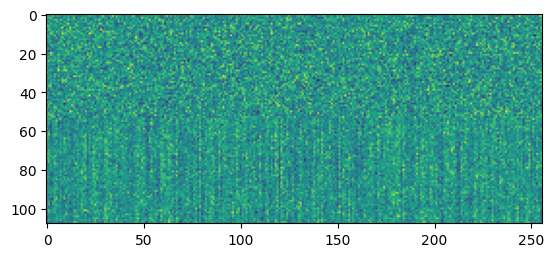

In [64]:
plt.imshow(model.positional_encoding.detach().cpu().numpy());

# Final Timing

In [ ]:
print('%.1f seconds passed total '%(time.time()-t0start) )
print('%.1f minutes passed total '%( (time.time()-t0start)/60)  )
print('%.2f hours passed total '%( (time.time()-t0start)/3600)  )